# LMM vetting

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf


/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_33417/1005038584.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Load in data from statsmodels documentation

In [109]:
data = sm.datasets.get_rdataset("dietox", "geepack").data
md = smf.mixedlm("Weight ~ Time", data, groups=data["Pig"])
mdf = md.fit(method=["lbfgs"])

In [110]:
data

,Pig,Evit,Cu,Litter,Start,Weight,Feed,Time
0,4601,Evit000,Cu000,1,26.5,26.50000,NaN,1
1,4601,Evit000,Cu000,1,26.5,27.59999,5.200005,2
2,4601,Evit000,Cu000,1,26.5,36.50000,17.600000,3
3,4601,Evit000,Cu000,1,26.5,40.29999,28.500000,4
4,4601,Evit000,Cu000,1,26.5,49.09998,45.200001,5
...,...,...,...,...,...,...,...,...
856,8442,Evit000,Cu175,24,25.7,73.19995,83.800003,8
857,8442,Evit000,Cu175,24,25.7,81.69995,99.800003,9
858,8442,Evit000,Cu175,24,25.7,90.29999,115.200001,10
859,8442,Evit000,Cu175,24,25.7,96.00000,133.200001,11


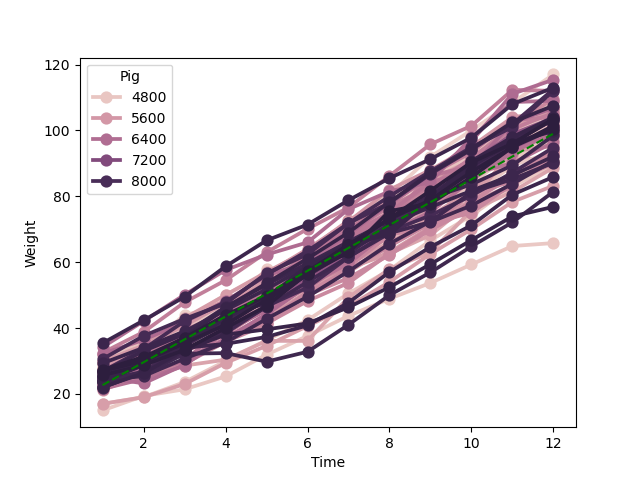

In [111]:
%matplotlib widget
_, ax = plt.subplots()
sns.pointplot(data=data, x="Time", y="Weight", hue="Pig", native_scale=True, ax=ax)
ax.plot([1, 12], np.array([1, 12])*mdf.params.Time + mdf.params.Intercept, 'g--')

In [112]:
md = smf.mixedlm("Weight ~ Time", data, groups=data["Pig"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Weight    
No. Observations: 861     Method:             REML      
No. Groups:       72      Scale:              11.3669   
Min. group size:  11      Log-Likelihood:     -2404.7753
Max. group size:  12      Converged:          Yes       
Mean group size:  12.0                                  
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept    15.724    0.788  19.952 0.000 14.179 17.268
Time          6.943    0.033 207.939 0.000  6.877  7.008
Group Var    40.395    2.149                            



In [113]:
mdf.params

Intercept    15.723523
Time          6.942505
Group Var     3.553717
dtype: float64

In [114]:
mdf.fe_params

Intercept    15.723523
Time          6.942505
dtype: float64

Now plot a subset of pigs with lines overlaid to show effect

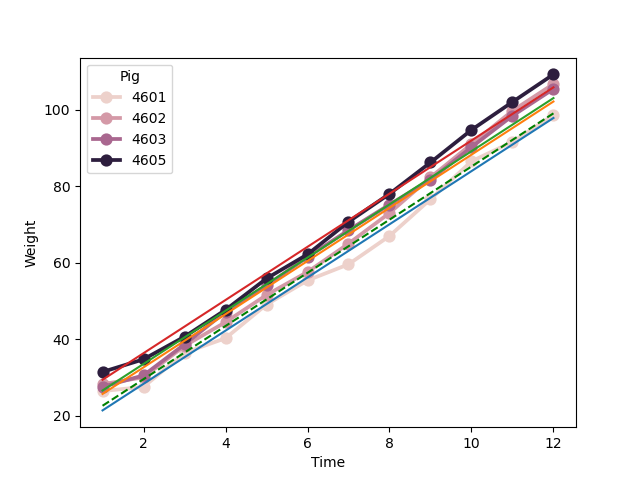

In [141]:
%matplotlib widget
_, ax = plt.subplots()
data_sub = data[(data.Pig >= 4601) & (data.Pig <= 4605)]
sns.pointplot(data=data_sub, x="Time", y="Weight", hue="Pig", native_scale=True, ax=ax)
ax.plot([1, 12], np.array([1, 12])*mdf.params.Time + mdf.params.Intercept, 'g--')
for pig, pig_intercept in mdf.random_effects.items():
    if (pig >= 4601) & (pig <=4605):
        ax.plot([1, 12], np.array([1, 12])*mdf.params.Time + mdf.params.Intercept + pig_intercept.values)

### Simulate Data
UCLA example - all data points correlated but same data is inversely correlated within each doctor

#### First, simulate data with a clear positive trend across individuals but with a negative correlation within doctors albeit with a small variance for each doctor.

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: outcome
No. Observations: 60      Method:             REML   
No. Groups:       6       Scale:              0.0422 
Min. group size:  10      Log-Likelihood:     4.8980 
Max. group size:  10      Converged:          Yes    
Mean group size:  10.0                               
-----------------------------------------------------
           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------
Intercept  -0.003    0.052 -0.054 0.957 -0.105  0.099
predictor   1.003    0.018 55.901 0.000  0.968  1.038
Doctor Var  0.000    0.043                           



/Users/nkinsky/mambaforge/envs/eraser/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/nkinsky/mambaforge/envs/eraser/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


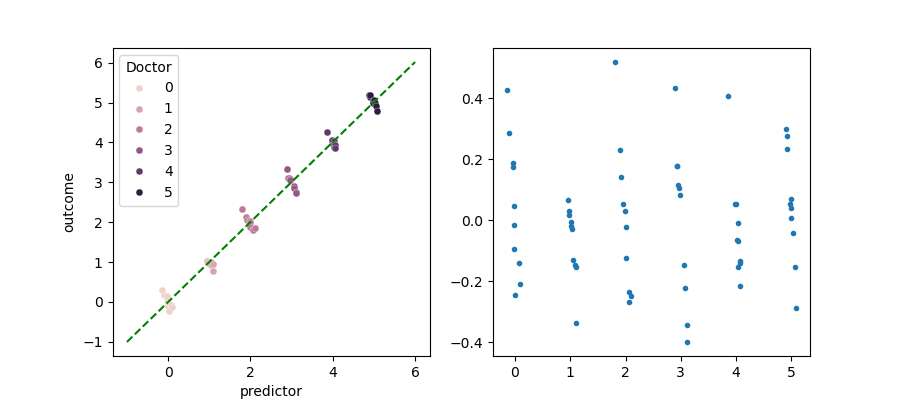

In [216]:
df_list = []
for doctor in range(6):
    xd = np.random.randn(10)*0.07
    yd = -1.6 * xd + np.random.randn(10)*0.07
    x = doctor + xd
    y = doctor + yd
    df_list.append(pd.DataFrame({"Doctor": doctor, "predictor": x, "outcome": y}))

df = pd.concat(df_list, axis=0).reset_index().drop(columns="index")

_, axs = plt.subplots(1, 2, figsize=(9, 4))
ax = axs[0]
sns.pointplot(data=df, x="predictor", y="outcome", hue="Doctor", native_scale=True, linestyles="", markersize=5,
              markeredgewidth=0.2, markeredgecolor="w", ax=ax)

# df.sample(5)


md = smf.mixedlm("outcome ~ predictor", df, groups="Doctor")
mdf = md.fit(reml=True)
print(mdf.summary())

ax.plot([-1, 6], np.array([-1, 6])*mdf.params.predictor + mdf.params.Intercept, 'g--')

# Plot residuals vs fitted
ax = axs[1]
ax.plot(mdf.fittedvalues, mdf.resid, '.')

In [215]:
mdf.random_effects

{0: Doctor   -2.100568
 Doctor    0.984955
 dtype: float64,
 1: Doctor   -0.144704
 Doctor   -0.081927
 dtype: float64,
 2: Doctor    0.044406
 Doctor    0.764098
 dtype: float64,
 3: Doctor   -0.272706
 Doctor    1.233705
 dtype: float64,
 4: Doctor   -0.471661
 Doctor    1.405651
 dtype: float64,
 5: Doctor   -0.604889
 Doctor    1.520240
 dtype: float64}

#### Now, do a similar simulation but make the variance within each doctor a lot larger.

This doesn't quite work as the slope and intercept found now matches the within doctor trend but does not do a good job of capturing the overall trend.

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: outcome 
No. Observations: 60      Method:             REML    
No. Groups:       6       Scale:              0.1259  
Min. group size:  10      Log-Likelihood:     -43.5149
Max. group size:  10      Converged:          Yes     
Mean group size:  10.0                                
------------------------------------------------------
           Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept   5.796    1.780   3.256 0.001  2.308  9.285
predictor  -1.328    0.127 -10.441 0.000 -1.577 -1.079
Doctor Var 18.379   34.846                            



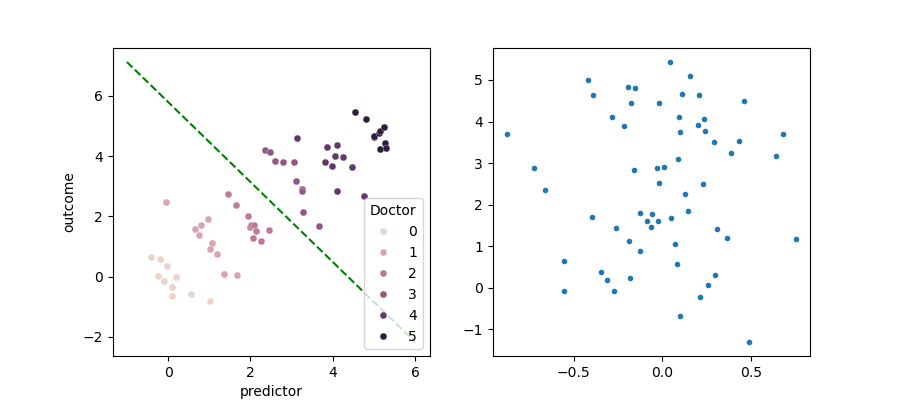

In [217]:
df_list = []
for doctor in range(6):
    xd = np.random.randn(10)*0.4
    yd = -1.6 * xd + np.random.randn(10)*0.4
    x = doctor + xd
    y = doctor + yd
    df_list.append(pd.DataFrame({"Doctor": doctor, "predictor": x, "outcome": y}))

df = pd.concat(df_list, axis=0).reset_index().drop(columns="index")

_, axs = plt.subplots(1, 2, figsize=(9, 4))
ax = axs[0]
sns.pointplot(data=df, x="predictor", y="outcome", hue="Doctor", native_scale=True, linestyles="", markersize=5,
              markeredgewidth=0.2, markeredgecolor="w", ax=ax)

# df.sample(5)


md = smf.mixedlm("outcome ~ predictor", df, groups="Doctor")
mdf = md.fit(reml=True)
print(mdf.summary())

ax.plot([-1, 6], np.array([-1, 6])*mdf.params.predictor + mdf.params.Intercept, 'g--')

# Plot residuals vs fitted
ax = axs[1]
ax.plot(mdf.resid, mdf.fittedvalues, ".")

In [69]:
mdf.random_effects[0]

Doctor   -6.314386
dtype: float64

How do we fix this?
Add in random effects intercept for each doctor!

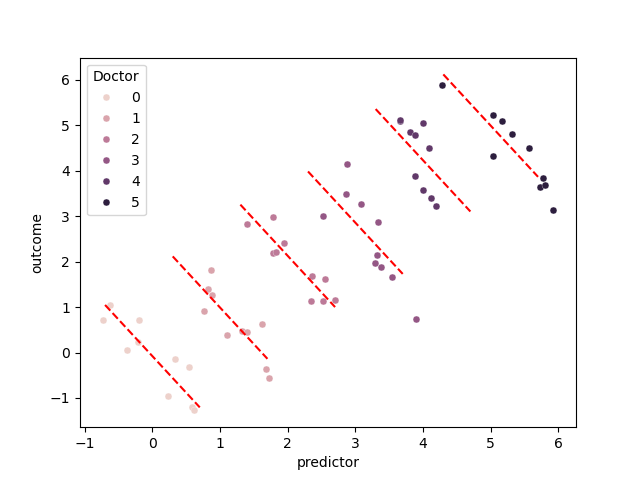

In [75]:
_, ax = plt.subplots()
sns.pointplot(data=df, x="predictor", y="outcome", hue="Doctor", native_scale=True, linestyles="", markersize=5,
              markeredgewidth=0.2, markeredgecolor="w")

for doctor in range(6):
    intercept = mdf.params.Intercept + mdf.random_effects[doctor].Doctor
    x = doctor + np.array([-0.7, 0.7]) 
    ax.plot(x, x * mdf.params.predictor + intercept, 'r--')


Ok, so this captures the overall trend within a doctor well but not the fixed effect very well because the variance within a doctor is so high. 

#### Try to capture both fixed and random effects above

              Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    outcome 
No. Observations:      60         Method:                REML    
No. Groups:            6          Scale:                 0.1826  
Min. group size:       10         Log-Likelihood:        -54.1270
Max. group size:       10         Converged:             No      
Mean group size:       10.0                                      
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               6.759    2.362  2.862 0.004  2.131 11.388
predictor              -1.707    0.183 -9.314 0.000 -2.067 -1.348
Doctor Var             25.508   87.806                           
Doctor x predictor Cov -0.078   10.771                           
predictor Var           0.000    1.135                           



/Users/nkinsky/mambaforge/envs/eraser/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nkinsky/mambaforge/envs/eraser/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/nkinsky/mambaforge/envs/eraser/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nkinsky/mambaforge/envs/eraser/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/nkinsky/mambaforge/envs/eraser/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: 

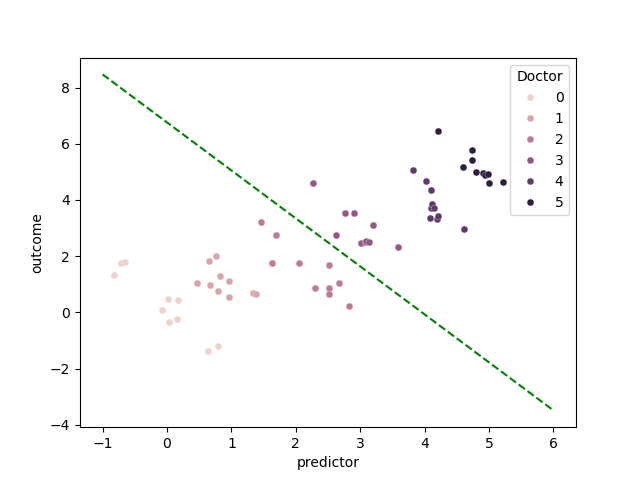

In [146]:
df_list = []
for doctor in range(6):
    xd = np.random.randn(10)*0.4
    yd = -1.6 * xd + np.random.randn(10)*0.4
    x = doctor + xd
    y = doctor + yd
    df_list.append(pd.DataFrame({"Doctor": doctor, "predictor": x, "outcome": y}))

df = pd.concat(df_list, axis=0).reset_index().drop(columns="index")

_, ax = plt.subplots()
sns.pointplot(data=df, x="predictor", y="outcome", hue="Doctor", native_scale=True, linestyles="", markersize=5,
              markeredgewidth=0.2, markeredgecolor="w")

# df.sample(5)


md = smf.mixedlm("outcome ~ predictor", df, groups="Doctor", re_formula="~predictor")
mdf = md.fit(reml=True)
print(mdf.summary())

ax.plot([-1, 6], np.array([-1, 6])*mdf.params.predictor + mdf.params.Intercept, 'g--')

### Plot residuals versus fitted!
Do for each group too!
Q-Q plot.

See https://www.youtube.com/watch?v=QCqF-2E86r0 at ~ 10 min for diagnostic plots.

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    outcome
No. Observations:     60         Method:                REML   
No. Groups:           6          Scale:                 0.0043 
Min. group size:      10         Log-Likelihood:        67.3928
Max. group size:      10         Converged:             No     
Mean group size:      10.0                                     
---------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            0.023    0.033   0.702 0.483 -0.042  0.088
predictor           -1.598    0.120 -13.304 0.000 -1.833 -1.362
Doctor               2.593    0.120  21.615 0.000  2.358  2.828
Doctor Var           0.002                                     
Doctor x Doctor Cov -0.001    0.014                            
Doctor Var           0.000    0.014                  

/Users/nkinsky/mambaforge/envs/eraser/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nkinsky/mambaforge/envs/eraser/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/nkinsky/mambaforge/envs/eraser/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nkinsky/mambaforge/envs/eraser/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/nkinsky/mambaforge/envs/eraser/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: 

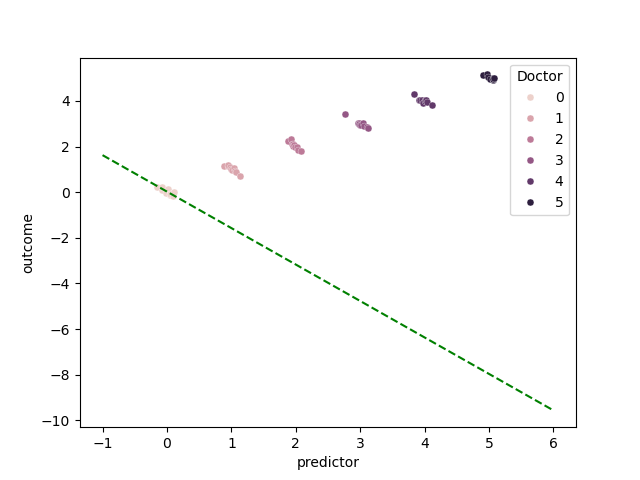

In [197]:
df_list = []
for doctor in range(6):
    xd = np.random.randn(10)*0.07
    yd = -1.6 * xd + np.random.randn(10)*0.07
    x = doctor + xd
    y = doctor + yd
    df_list.append(pd.DataFrame({"Doctor": doctor, "predictor": x, "outcome": y}))

df = pd.concat(df_list, axis=0).reset_index().drop(columns="index")

_, ax = plt.subplots()
sns.pointplot(data=df, x="predictor", y="outcome", hue="Doctor", native_scale=True, linestyles="", markersize=5,
              markeredgewidth=0.2, markeredgecolor="w")

# df.sample(5)


md = smf.mixedlm("outcome ~ predictor + Doctor", df, groups="Doctor", re_formula="~Doctor")
mdf = md.fit(reml=True)
print(mdf.summary())

# ax.plot([-1, 6], np.array([-1, 6])*mdf.params.predictor + np.array([-1, 6])*mdf.params.Doctor +  mdf.params.Intercept, 'g--')
ax.plot([-1, 6], np.array([-1, 6])*mdf.params.predictor +  mdf.params.Intercept, 'g--')

# Plot residuals vs fitted.

In [200]:
mdf.fittedvalues

0     0.062104
1     0.150049
2    -0.122972
3    -0.041045
4     0.164017
5     0.263918
6     0.007510
7    -0.040146
8    -0.058266
9    -0.136233
10    1.100020
11    0.934261
12    1.067529
13    0.963502
14    1.003513
15    0.912763
16    1.032167
17    1.194215
18    1.095030
19    0.800733
20    2.120783
21    2.080200
22    1.954338
23    1.987865
24    1.894484
25    2.210181
26    2.101145
27    2.060002
28    2.077221
29    2.041188
30    3.029429
31    2.833430
32    3.382945
33    3.063356
34    3.045218
35    2.907311
36    2.993485
37    3.000614
38    2.813447
39    2.943541
40    4.060647
41    3.950805
42    3.983152
43    4.136084
44    4.036543
45    3.925460
46    4.240185
47    3.809770
48    3.985271
49    4.087824
50    4.921865
51    4.936921
52    5.103170
53    4.941021
54    5.010862
55    4.932677
56    5.070667
57    5.183161
58    4.948558
59    4.949758
dtype: float64

In [199]:
mdf.resid

0    -0.080134
1     0.078476
2    -0.026206
3    -0.041419
4    -0.059834
5    -0.031874
6     0.141505
7    -0.096000
8    -0.002122
9     0.127965
10    0.034157
11   -0.018947
12    0.027086
13    0.110496
14   -0.018348
15   -0.019447
16   -0.019870
17   -0.069586
18    0.087671
19   -0.092278
20    0.200607
21    0.049686
22   -0.104953
23    0.007638
24   -0.078651
25    0.012235
26    0.004067
27    0.009951
28   -0.065530
29   -0.050029
30   -0.030437
31    0.030836
32    0.028967
33   -0.031823
34   -0.017769
35   -0.006477
36   -0.031681
37   -0.046946
38    0.008891
39    0.074625
40   -0.003017
41    0.087342
42    0.026119
43   -0.099580
44   -0.133682
45    0.027967
46    0.048505
47   -0.001372
48    0.043014
49   -0.042248
50    0.065896
51    0.056676
52    0.056352
53   -0.000593
54   -0.052429
55    0.027745
56   -0.025699
57   -0.033959
58    0.013505
59   -0.055039
dtype: float64

In [192]:
mdf.fe_params

Intercept    0.004314
predictor   -1.722307
Doctor       2.720975
dtype: float64

In [198]:
mdf.random_effects

{0: Doctor    0.005403
 Doctor   -0.002022
 dtype: float64,
 1: Doctor    0.006833
 Doctor   -0.002195
 dtype: float64,
 2: Doctor   -0.001965
 Doctor    0.000218
 dtype: float64,
 3: Doctor    0.001397
 Doctor   -0.001654
 dtype: float64,
 4: Doctor    0.012172
 Doctor   -0.007802
 dtype: float64,
 5: Doctor   -0.023840
 Doctor    0.013456
 dtype: float64}

In [44]:
md = smf.mixedlm("outcome ~ predictor", df, groups="Doctor")
mdf = md.fit(reml=True)
mdf.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
        Mixed Linear Model Regression Results
======================================================
Model:            MixedLM Dependent Variable: outcome 
No. Observations: 60      Method:             REML    
No. Groups:       6       Scale:              0.0386  
Min. group size:  10      Log-Likelihood:     -10.9681
Max. group size:  10      Converged:          Yes     
Mean group size:  10.0                                
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    5.335    1.670  3.195 0.001  2.062  8.608
predictor   -1.113    0.160 -6.963 0.000 -1.427 -0.800
Doctor Var  15.788   54.805                           
======================================================

"""

In [ ]:
md = smf.mixedlm("outcome ~ predictor", df, groups="Doctor", vc = {